In [1]:
# Random Imports
import os
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

# Regular schema dictates that we put DATAPATH
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))
os.environ['WANDB_NOTEBOOK_NAME'] = 'train.ipynb'

%load_ext yamlmagic
%load_ext autoreload
%autoreload 2

## Define said jobs

In [2]:
%%yaml default_cfg 

experiment:
  seed: 42
    
dataloader:
  batch_size: 1 
  num_workers: '?' 
  pin_memory: False 

optim: 
  _class: torch.optim.Adam
  lr: 3.0e-4
  weight_decay: 0.0
  
# For MultiClass
train:
  epochs: 100 
  eval_freq: 5
  augmentations: None

log:
  checkpoint_freq: 5 
  root: '?'
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      from_logits: True
      batch_reduction: 'mean' 
      ignore_index: 0

loss_func: 
  _class: ionpy.loss.SoftDiceLoss
  from_logits: True
  batch_reduction: 'mean' 
  ignore_index: 0 # Optionally ignore the background class

# For Binary

# train:
#   epochs: 500 
#   eval_freq: 50

# log:
#   checkpoint_freq: 50 
#   root: '?'
#   metrics:
#     dice_score:
#       _fn: ionpy.metrics.dice_score
#       from_logits: True
#       batch_reduction: 'mean' 

# loss_func: 
#   _class: ionpy.loss.SoftDiceLoss
#   from_logits: True
#   batch_reduction: 'mean' 

<IPython.core.display.Javascript object>

In [3]:
%%yaml model_cfg  

model:
  _class: ese.experiment.models.UNet
  filters: '?'
  convs_per_block: 3

<IPython.core.display.Javascript object>

In [4]:
%%yaml dataset_cfg 

# data:
#   _class: ese.experiment.datasets.WMH
#   annotator: observer_o12
#   axis: 0
#   preload: False 
#   num_slices: 1
#   task: Amsterdam 
#   version: 0.2
#   in_channels: 1
#   out_channels: 2 

# data:
#   _class: ese.experiment.datasets.COCO 
#   in_channels: 3
#   out_channels: 80

data:
  _class: ese.experiment.datasets.OxfordPets
  preload: True
  version: 0.1
  num_classes: all 
  in_channels: 3
  out_channels: 38 # 37 + 1 (background)

# data:
#   _class: ese.experiment.datasets.BinaryPets
#   preload: True
#   version: 0.1
#   in_channels: 3
#   out_channels: 2

<IPython.core.display.Javascript object>

In [5]:
%%yaml lite_aug_cfg

- RandomAffine:
    p: 0.5
    degrees: [0, 360]
    translate: [0, 0.2]
    scale: [0.8, 1.1]
- RandomVariableElasticTransform:
    p: 0.75
    alpha: [1, 2] 
    sigma: [7, 9]
- RandomHorizontalFlip:
    p: 0.5
- RandomVerticalFlip:
    p: 0.5

<IPython.core.display.Javascript object>

In [6]:
# %%yaml standard_aug_cfg 

# - RandomCrop:
#     _class: ese.experiment.augmentation.transforms.RandomCropSegmentation
#     size: [256, 256]

In [7]:
%%yaml callbacks_cfg

callbacks:
  step:
    - ese.experiment.callbacks.ShowPredictions:
        show_soft_pred: False 
  epoch:
    - ese.experiment.callbacks.WandbLogger
    - ionpy.callbacks.ETA
    - ionpy.callbacks.JobProgress
    - ionpy.callbacks.TerminateOnNaN
    - ionpy.callbacks.PrintLogged
    - ionpy.callbacks.ModelCheckpoint:
        monitor: dice_score
        phase: val

<IPython.core.display.Javascript object>

## Debug Station

In [8]:
# Need to define the experiment name
exp_name = '09_15_23_OxfordPetsPilot'

# Create the ablation options
option_set = [
    {
        'log.root': [f'/storage/vbutoi/scratch/ESE/{exp_name}'],
        'augmentations': [None],
        'dataloader.batch_size': [1],
        'dataloader.num_workers': [0],
        'optim.lr': [3.0e-4],
        'model.filters': [[128, 128, 128, 128, 128]]
    },
]

In [9]:
from ese.scripts.utils import get_option_product
from ionpy.util import Config

# Assemble base config
base_cfg = Config(default_cfg).update([model_cfg, dataset_cfg, callbacks_cfg])

# Get the configs
cfgs = get_option_product(exp_name, option_set, base_cfg)

In [10]:
len(cfgs)

1

## Running Jobs

Running CalibrationExperiment("/storage/vbutoi/scratch/ESE/debug/20230916_161739-DNWU-4a53a060846dc9424ca16c1fae243113")
---
augmentations: null
callbacks:
  epoch:
  - ionpy.callbacks.ETA
  - ionpy.callbacks.JobProgress
  - ionpy.callbacks.TerminateOnNaN
  - ionpy.callbacks.PrintLogged
  - ionpy.callbacks.ModelCheckpoint:
      monitor: dice_score
      phase: val
  step:
  - ese.experiment.callbacks.ShowPredictions:
      show_soft_pred: false
data:
  _class: ese.experiment.datasets.OxfordPets
  num_classes: all
  preload: true
  version: 0.1
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: false
experiment:
  seed: 42
log:
  checkpoint_freq: 5
  metrics:
    dice_score:
      _fn: ionpy.metrics.dice_score
      batch_reduction: mean
      from_logits: true
      ignore_index: 0
  root: /storage/vbutoi/scratch/ESE/debug
  wandb_string: exp_name:09_15_23_OxfordPetsPilot-augmentations:None-batch_size:1-num_workers:0-lr:0.0003-filters:[128,128,128,128,128]
loss_func:
  _class:

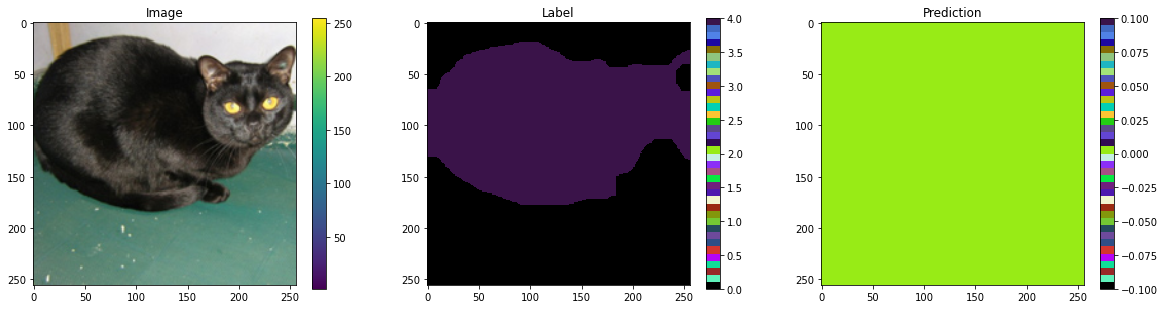

ValueError: 

In [11]:
from ese.experiment.experiment import run_ese_exp

run_ese_exp(
    config=cfgs[0], 
    gpu='3',
    run_name='debug',
    show_examples=True,
    wandb=False
)

In [ ]:
# from ese.experiment.experiment import submit_ese_exps 

# submit_ese_exps(
#     exp_name=exp_name,
#     config_list=cfgs,
#     available_gpus=['0', '1', '2', '3'],
#     wandb=True
# )